In [133]:
import torch
import torch.nn as nn

In [134]:
torch.functional.F.softmax(torch.randn(5,5).masked_fill(torch.tril(torch.ones(5,5), diagonal=0)==0, float('-inf')), dim=-1)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4069, 0.5931, 0.0000, 0.0000, 0.0000],
        [0.1448, 0.6067, 0.2486, 0.0000, 0.0000],
        [0.0755, 0.1803, 0.3225, 0.4217, 0.0000],
        [0.3266, 0.1780, 0.1382, 0.3371, 0.0201]])

In [135]:
X = []
Y = []

for a in torch.arange(0,113):
    for b in torch.arange(0,113):
        X.append(torch.tensor([a,b,113]))

        if a + b > 113:
            Y.append(torch.tensor([a + b - 113 - 1]))
        else:
            Y.append(torch.tensor([a + b -1]))

X = torch.stack(X)
Y = torch.stack(Y)

In [136]:
Y.max()

tensor(112)

In [137]:
torch.randint(1,50, (5,))

tensor([ 4,  1, 39, 39,  3])

In [138]:
max_sample = int(X.shape[0] * 0.3)
rand_idx = torch.randint(0, X.shape[0], (max_sample,))
X_subset = X[rand_idx]
Y_subset = Y[rand_idx]

In [139]:
max_tr = int(X_subset.shape[0] * 0.7)
max_tst = int(X_subset.shape[0] * (0.7 + 0.2))

X_tr, Y_tr = X_subset[0: max_tr], Y_subset[0: max_tr]
X_tst, Y_tst = X_subset[max_tr: max_tst], Y_subset[max_tr:max_tst]
X_val, Y_val = X_subset[max_tst:], Y_subset[max_tst:]

In [140]:
X_tr, Y_tr

(tensor([[108,  24, 113],
         [ 52,  64, 113],
         [ 55,  22, 113],
         ...,
         [ 96,  63, 113],
         [ 46,  88, 113],
         [112,  70, 113]]),
 tensor([[18],
         [ 2],
         [76],
         ...,
         [45],
         [20],
         [68]]))

In [141]:
X_subset.shape, Y_subset.shape

(torch.Size([3830, 3]), torch.Size([3830, 1]))

In [142]:
class Attention(nn.Module):
    def __init__(self):
        super().__init__() 

        self.query = nn.Linear(128, 32)
        self.key = nn.Linear(128, 32)
        self.value = nn.Linear(128, 32)

    def forward(self, x):
        query: torch.Tensor = self.query(x)
        key: torch.Tensor = self.key(x)
        value: torch.Tensor = self.value(x)

        sim_mat: torch.Tensor = query @ key.transpose( -1, -2 )

        # masked_sim_mat = sim_mat.masked_fill(torch.tril(sim_mat, diagonal=0)==0, float('-inf'))
        # normed_sim_mat = torch.functional.F.softmax(masked_sim_mat, dim=-1)
        normed_sim_mat = torch.functional.F.softmax(sim_mat, dim=-1)

        output = normed_sim_mat @ value

        return output
    
class MultiheadAttention(nn.Module):
    def __init__(self):
        super().__init__()

        self.attns = nn.ModuleList([Attention() for _ in range(4)])

    def forward(self, x):
        outputs = [attn(x) for attn in self.attns]
        concat_output = torch.concat(outputs, dim=-1)

        return concat_output




class Grokker(nn.Module):
    def __init__(self):
        super().__init__()

        self.tok_embd = nn.Embedding(114, 128)
        self.pos_embd = nn.Embedding(3, 128)
        
        self.linearup = nn.Linear(128, 512)
        self.lineardown = nn.Linear(512, 128)
        self.relu = nn.ReLU()

        self.attn = MultiheadAttention()

        self.unembd = nn.Linear(128, 113)

    def forward(self, x):
        tok_embd = self.tok_embd(x)
        pos_embd = self.pos_embd(torch.arange(0, 3, 1, device=x.device))

        embd = tok_embd + pos_embd

        x = self.attn(embd) + embd

        res_x = x
        # MLP

        x = self.linearup(x)
        x = self.relu(x)
        x = self.lineardown(x)
        x = x + res_x

        logits = self.unembd(x[:,2])

        return logits

In [143]:
# Device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Device: {device}")

Using MPS (Apple Silicon)
Device: mps


In [152]:
model = Grokker().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.5)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [153]:
for i in range(50_000):
    batch_ix = torch.randint(0, X_tr.shape[0], (32,))
    x = X_tr[batch_ix].to(device)
    y = Y_tr[batch_ix].to(device)

    logits = model(x)
    loss = torch.functional.F.cross_entropy(logits, y.squeeze(-1))
    
    # Calculate training accuracy
    train_preds = logits.argmax(dim=-1)
    train_acc = (train_preds == y.squeeze(-1)).float().mean()

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    train_accuracies.append(train_acc.item())

    # Validation check every 1000 iterations
    if i % 500 == 0:
        with torch.no_grad():
            batch_ix = torch.randint(0, X_val.shape[0], (32,))
            x = X_val[batch_ix].to(device)
            y = Y_val[batch_ix].to(device)

            logits = model(x)
            val_loss = torch.functional.F.cross_entropy(logits, y.squeeze(-1))
            
            # Calculate validation accuracy
            val_preds = logits.argmax(dim=-1)
            val_acc = (val_preds == y.squeeze(-1)).float().mean()
            
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc.item())
        
        print(f"epoch: {i}, train loss: {loss.item():.4f}, train acc: {train_acc.item():.4f}, val loss: {val_loss.item():.4f}, val acc: {val_acc.item():.4f}")

epoch: 0, train loss: 5.4147, train acc: 0.0000, val loss: 5.1581, val acc: 0.0000
epoch: 500, train loss: 3.5685, train acc: 0.2188, val loss: 5.1170, val acc: 0.1250
epoch: 1000, train loss: 3.1873, train acc: 0.3438, val loss: 5.7367, val acc: 0.0625
epoch: 1500, train loss: 2.4578, train acc: 0.3750, val loss: 5.7911, val acc: 0.1250
epoch: 2000, train loss: 1.7212, train acc: 0.6875, val loss: 5.9977, val acc: 0.1875
epoch: 2500, train loss: 0.8257, train acc: 0.9062, val loss: 6.5431, val acc: 0.2188
epoch: 3000, train loss: 0.6545, train acc: 0.9375, val loss: 7.3134, val acc: 0.1562
epoch: 3500, train loss: 0.7118, train acc: 0.9062, val loss: 7.3787, val acc: 0.1562
epoch: 4000, train loss: 0.5860, train acc: 0.9375, val loss: 8.4564, val acc: 0.1250
epoch: 4500, train loss: 0.5436, train acc: 0.9688, val loss: 7.0673, val acc: 0.2188
epoch: 5000, train loss: 0.3335, train acc: 0.9688, val loss: 9.6974, val acc: 0.0625
epoch: 5500, train loss: 0.3413, train acc: 0.9375, val lo

epoch: 0, train loss: 5.4147, train acc: 0.0000, val loss: 5.1581, val acc: 0.0000
epoch: 500, train loss: 3.5685, train acc: 0.2188, val loss: 5.1170, val acc: 0.1250
epoch: 1000, train loss: 3.1873, train acc: 0.3438, val loss: 5.7367, val acc: 0.0625
epoch: 1500, train loss: 2.4578, train acc: 0.3750, val loss: 5.7911, val acc: 0.1250
epoch: 2000, train loss: 1.7212, train acc: 0.6875, val loss: 5.9977, val acc: 0.1875
epoch: 2500, train loss: 0.8257, train acc: 0.9062, val loss: 6.5431, val acc: 0.2188
epoch: 3000, train loss: 0.6545, train acc: 0.9375, val loss: 7.3134, val acc: 0.1562
epoch: 3500, train loss: 0.7118, train acc: 0.9062, val loss: 7.3787, val acc: 0.1562
epoch: 4000, train loss: 0.5860, train acc: 0.9375, val loss: 8.4564, val acc: 0.1250
epoch: 4500, train loss: 0.5436, train acc: 0.9688, val loss: 7.0673, val acc: 0.2188
epoch: 5000, train loss: 0.3335, train acc: 0.9688, val loss: 9.6974, val acc: 0.0625
epoch: 5500, train loss: 0.3413, train acc: 0.9375, val lo

KeyboardInterrupt: 

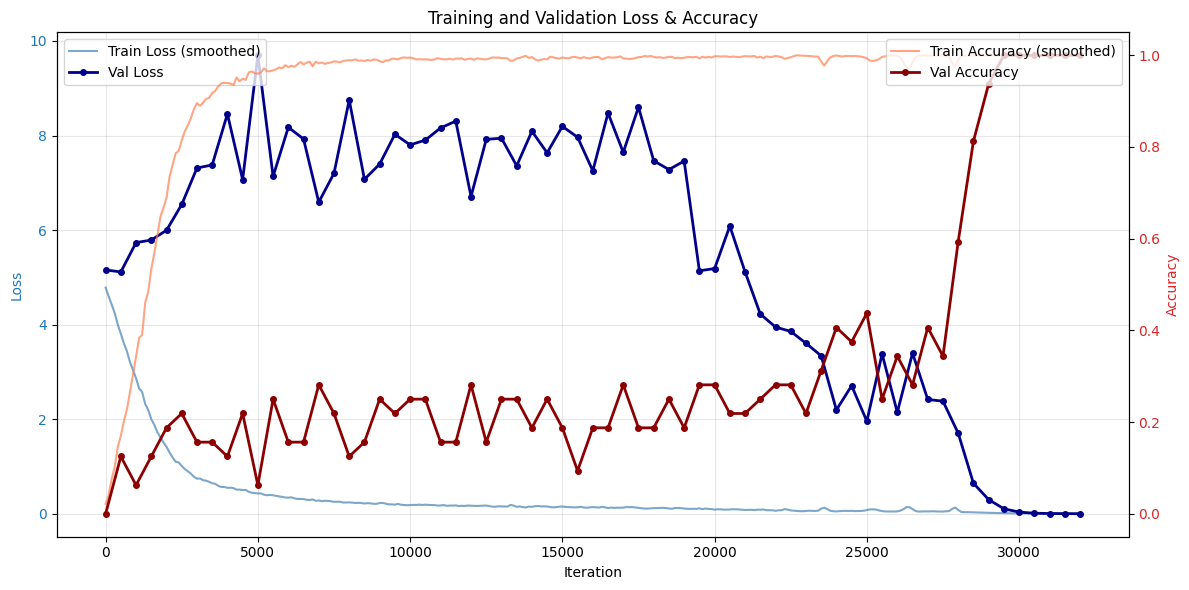

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Smooth training data by taking mean of every 100 epochs
def smooth_data(data, bin_size=100):
    smoothed = []
    for i in range(0, len(data), bin_size):
        smoothed.append(np.mean(data[i:i+bin_size]))
    return smoothed

# Smooth validation data with a moving average
def smooth_val_data(data, window_size=5):
    if len(data) < window_size:
        return data
    smoothed = []
    for i in range(len(data)):
        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(data), i + window_size // 2 + 1)
        smoothed.append(np.mean(data[start_idx:end_idx]))
    return smoothed

val_x_positions = [i * 500 for i in range(len(val_losses))]

# Smooth the training data
smoothed_train_losses = smooth_data(train_losses, 100)
smoothed_train_accuracies = smooth_data(train_accuracies, 100)

# Smooth the validation data
smoothed_val_losses = smooth_val_data(val_losses, window_size=5)
smoothed_val_accuracies = smooth_val_data(val_accuracies, window_size=5)

# X positions for smoothed training data
smoothed_train_x = [i * 100 for i in range(len(smoothed_train_losses))]

# Create single plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot losses on left y-axis
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(smoothed_train_x, smoothed_train_losses, label='Train Loss (smoothed)', color='steelblue', alpha=0.7)
ax1.plot(val_x_positions, smoothed_val_losses, label='Val Loss (smoothed)', linewidth=2, marker='o', markersize=4, color='darkblue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Create second y-axis for accuracies
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:red')
ax2.plot(smoothed_train_x, smoothed_train_accuracies, label='Train Accuracy (smoothed)', color='coral', alpha=0.7)
ax2.plot(val_x_positions, smoothed_val_accuracies, label='Val Accuracy (smoothed)', linewidth=2, marker='o', markersize=4, color='darkred')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('Training and Validation Loss & Accuracy')
plt.tight_layout()
plt.show()